# EEG Group Analysis

This notebook loads preprocessed data, parses event files, creates epochs, computes grand averages, and visualizes ERP components.

In [ ]:
import mne
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

subjects = subjects = [
        'sub-13',
        # 'sub-14',
        # 'sub-15',
        # 'sub-12',
        'sub-08',
        'sub-06',
        'sub-07',
        # 'sub-11',
        'sub-16',
        'sub-02']

sessions = ["ses-EMS", "ses-Vibro", "ses-Visual"]
base_path = Path("../ds003846-2.0.2")
processed_path = Path("../processed_eeg_data")
event_id = {"normal": 2, "conflict": 3}
tmin, tmax = -0.3, 0.7

group_evokeds = {sess: {"normal": [], "conflict": []} for sess in sessions}


In [10]:
for subject in subjects:
    for session in sessions:
        print(f"Processing {subject}, {session}...")
        processed_raw_file = processed_path / subject / f"{session}_cleaned_raw.fif"
        raw = mne.io.read_raw_fif(str(processed_raw_file), preload=True)

        events_file = base_path / subject / session / "eeg" / f"{subject}_{session}_task-PredictionError_events.tsv"
        events_df = pd.read_csv(events_file, sep="\t")
        events_list = []
        for _, row in events_df.iterrows():
            event_dict = dict(item.split(":") for item in row["value"].split(";"))
            if "box" in event_dict and event_dict["box"] == "touched":
                onset_sec = float(row["onset"])
                sample_index = int(round(onset_sec * raw.info["sfreq"]))
                cond_label = event_dict["normal_or_conflict"]
                events_list.append([sample_index, 0, event_id[cond_label]])
        events_array = np.array(events_list, int)

        epochs = mne.Epochs(raw, events_array, event_id=event_id, tmin=tmin, tmax=tmax,
                            baseline=(None, 0), preload=True, event_repeated="drop")

        peak_to_peak = np.ptp(epochs.get_data(), axis=2).mean(axis=1)
        threshold = np.percentile(peak_to_peak, 80)
        noisy_epochs = peak_to_peak > threshold
        epochs.drop(indices=np.where(noisy_epochs)[0], reason="manual")

        epochs_normal = epochs["normal"].pick_channels(["FCz"])
        epochs_conflict = epochs["conflict"].pick_channels(["FCz"])

        group_evokeds[session]["normal"].append(epochs_normal)
        group_evokeds[session]["conflict"].append(epochs_conflict)


Processing sub-02, ses-EMS...
Opening raw data file ../processed_eeg_data/sub-02/ses-EMS_cleaned_raw.fif...
    Range : 0 ... 129016 =      0.000 ...   516.064 secs
Ready.
Reading 0 ... 129016  =      0.000 ...   516.064 secs...
Not setting metadata
200 matching events found
Setting baseline interval to [-0.3, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 200 events and 251 original time points ...
0 bad epochs dropped
Dropped 40 epochs: 16, 17, 50, 51, 72, 73, 80, 81, 86, 87, 88, 89, 94, 95, 100, 101, 102, 103, 104, 105, 106, 107, 126, 127, 138, 139, 148, 149, 166, 167, 168, 169, 178, 179, 182, 183, 184, 185, 186, 187
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Processing sub-02, ses-Vibro...
Opening raw data file ../processed_eeg_data/sub-02/ses-Vibro_cleaned_raw.fif...
    Range : 0 ... 419385 =      0.0

Not setting metadata
122 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
38 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
198 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
86 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
170 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
70 matching events found
Applying baseline correction (mode: mean)
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


/var/folders/1d/9y0bdfts6tg_s3kydbcry_d00000gn/T/ipykernel_20461/1875031238.py:7: RuntimeWarning: filter_length (331) is longer than the signal (251), distortion is likely. Reduce filter length or filter a longer signal.
  evoked_normal = all_normal.average().filter(l_freq=None, h_freq=10, verbose=False)
/var/folders/1d/9y0bdfts6tg_s3kydbcry_d00000gn/T/ipykernel_20461/1875031238.py:8: RuntimeWarning: filter_length (331) is longer than the signal (251), distortion is likely. Reduce filter length or filter a longer signal.
  evoked_conflict = all_conflict.average().filter(l_freq=None, h_freq=10, verbose=False)
/var/folders/1d/9y0bdfts6tg_s3kydbcry_d00000gn/T/ipykernel_20461/1875031238.py:7: RuntimeWarning: filter_length (331) is longer than the signal (251), distortion is likely. Reduce filter length or filter a longer signal.
  evoked_normal = all_normal.average().filter(l_freq=None, h_freq=10, verbose=False)
/var/folders/1d/9y0bdfts6tg_s3kydbcry_d00000gn/T/ipykernel_20461/1875031238.py

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


/var/folders/1d/9y0bdfts6tg_s3kydbcry_d00000gn/T/ipykernel_20461/1875031238.py:21: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  plot_compare_evokeds({sess: grand_averages[sess]["difference"] for sess in sessions},
/var/folders/1d/9y0bdfts6tg_s3kydbcry_d00000gn/T/ipykernel_20461/1875031238.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


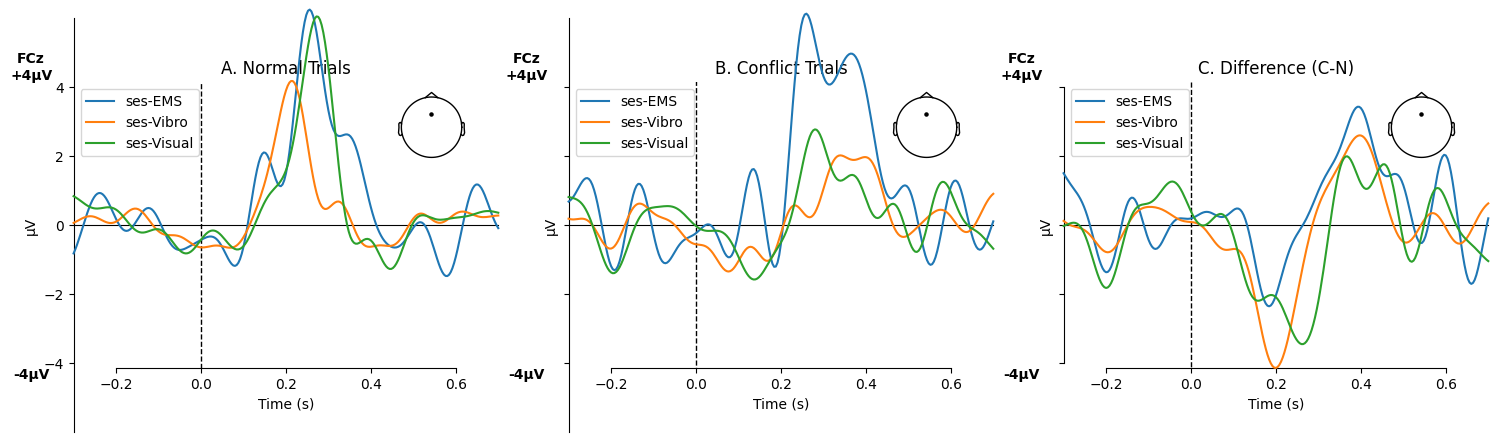

In [11]:
from mne.viz import plot_compare_evokeds

grand_averages = {}
for session in sessions:
    all_normal = mne.concatenate_epochs(group_evokeds[session]["normal"])
    all_conflict = mne.concatenate_epochs(group_evokeds[session]["conflict"])
    evoked_normal = all_normal.average().filter(l_freq=None, h_freq=10, verbose=False)
    evoked_conflict = all_conflict.average().filter(l_freq=None, h_freq=10, verbose=False)
    evoked_diff = mne.combine_evoked([evoked_conflict, evoked_normal], weights=[1, -1])
    grand_averages[session] = {"normal": evoked_normal, "conflict": evoked_conflict, "difference": evoked_diff}

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
channel_name = grand_averages[sessions[0]]["normal"].info["ch_names"][0]

plot_compare_evokeds({sess: grand_averages[sess]["normal"] for sess in sessions},
                     picks=channel_name, combine="mean", ci=True, axes=axes[0],
                     title="A. Normal Trials", show=False)
plot_compare_evokeds({sess: grand_averages[sess]["conflict"] for sess in sessions},
                     picks=channel_name, combine="mean", ci=True, axes=axes[1],
                     title="B. Conflict Trials", show=False)
plot_compare_evokeds({sess: grand_averages[sess]["difference"] for sess in sessions},
                     picks=channel_name, combine="mean", ci=True, axes=axes[2],
                     title="C. Difference (C-N)", show=False)

for ax in axes:
    y_min, y_max = ax.get_ylim()
    ax.text(ax.get_xlim()[0] - 0.1, y_max, f"{channel_name}\n+{int(y_max)}µV",
            fontsize=10, ha="center", va="bottom", weight="bold")
    ax.text(ax.get_xlim()[0] - 0.1, y_min, f"-{int(abs(y_min))}µV",
            fontsize=10, ha="center", va="top", weight="bold")
plt.tight_layout()
plt.show()


In [12]:
for session, averages in grand_averages.items():
    print(f"Session: {session}")
    for cond, evoked in averages.items():
        print(f"  {cond}: nave = {evoked.nave}")


Session: ses-EMS
  normal: nave = 122
  conflict: nave = 38
  difference: nave = 28.974999999999998
Session: ses-Vibro
  normal: nave = 198
  conflict: nave = 86
  difference: nave = 59.95774647887323
Session: ses-Visual
  normal: nave = 170
  conflict: nave = 70
  difference: nave = 49.583333333333336
